In [2]:
library(sf)
library(ggplot2)
library("rnaturalearth")
library("rnaturalearthdata")
library(dplyr)
library(glue)

pcolors = c("#FFBE0B", "#FF006E", "#8338EC", "#5A96FF", "#880D1E", "#4CC9F0")

Linking to GEOS 3.12.1, GDAL 3.8.4, PROJ 9.4.0; sf_use_s2() is TRUE


Attaching package: ‘rnaturalearthdata’


The following object is masked from ‘package:rnaturalearth’:

    countries110



Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




In [ ]:
# 31s à s'exécuter sur Stuart
data_full_dir = "../data/donnees-synop-essentielles-omm.csv"
# 9s à s'exécuter sur stuart
data_ext10_dir = "../data/donnees_extracted_10.csv"
data_ext10M_dir = "../data/donnees_extracted_metro_10.csv"

full_data <- read.csv(data_ext10_dir, 
            sep=",", # à toggle en fonction du fichier (',' pour les extracts, ';' pour l'originel)
            na.string=c("","null","NaN"),
            header=TRUE, 
            stringsAsFactors=TRUE)

## Critère : latitude et longitude

In [6]:
# extract latitudes and longitude
geo_data <- full_data[, c("ID.OMM.station", "Latitude", "Longitude")]
# make it unique
geo_data <- geo_data[!duplicated(geo_data["ID.OMM.station"]), ]
print(geo_data)

# replace names of rows by station id
row.names(geo_data) <- geo_data$ID.OMM.station
# and delete column
geo_data <- geo_data[, -which(names(geo_data) == "ID.OMM.station")]
print(geo_data)

     ID.OMM.station   Latitude  Longitude
1              7181  48.581000   5.959833
2             81405   4.822333 -52.365333
3              7627  43.005333   1.106833
4             78894  17.901500 -62.852167
5              7020  49.725167  -1.939833
6              7280  47.267833   5.088333
7              7015  50.570000   3.097500
8              7110  48.444167  -4.412000
9             81408   3.890667 -51.804667
10             7222  47.150000  -1.608833
11             7240  47.444500   0.727333
12             7747  42.737167   2.872833
13             7027  49.180000  -0.456167
14             7790  42.540667   9.485167
15            78925  14.595333 -60.995667
16             7510  44.830667  -0.691333
18             7761  41.918000   8.792667
19            61976 -15.887667  54.520667
20             7149  48.716833   2.384333
22             7072  49.209667   4.155333
23             7130  48.068833  -1.734000
24             7190  48.549500   7.640333
25            61980 -20.892500  55

 [1]    0.2158265    0.5172293    0.6730749    0.8085704    0.8781856
 [6]    0.8952877    0.9273192    0.9274829    0.9312736    0.9408687
[11]    0.9442055    0.9456233    0.9962667    1.0134477    1.0873582
[16]    1.0879934    1.1379653    1.1575676    1.1961177    1.4134002
[21]    1.4809208    1.5760456    1.5992289    1.8021521    1.8453360
[26]    2.1388092    2.1684568    2.2015406    2.3500432    2.3556888
[31]    2.3639532    2.3804502    2.5266629    2.8146829    2.8515853
[36]    2.9390072    3.0615327    4.1894859    4.3216153    4.6654939
[41]    5.1053322    5.4579590    5.7967258    6.2250897    6.9012750
[46]    8.0781362   12.0266704   13.4867924   13.6834181   13.7534505
[51]   22.5369771   22.6965200   25.9332052   33.0175068   50.7934968
[56]   56.0936649   64.0976091  100.3777346  153.3798477  969.8268081
[61] 1243.3898669


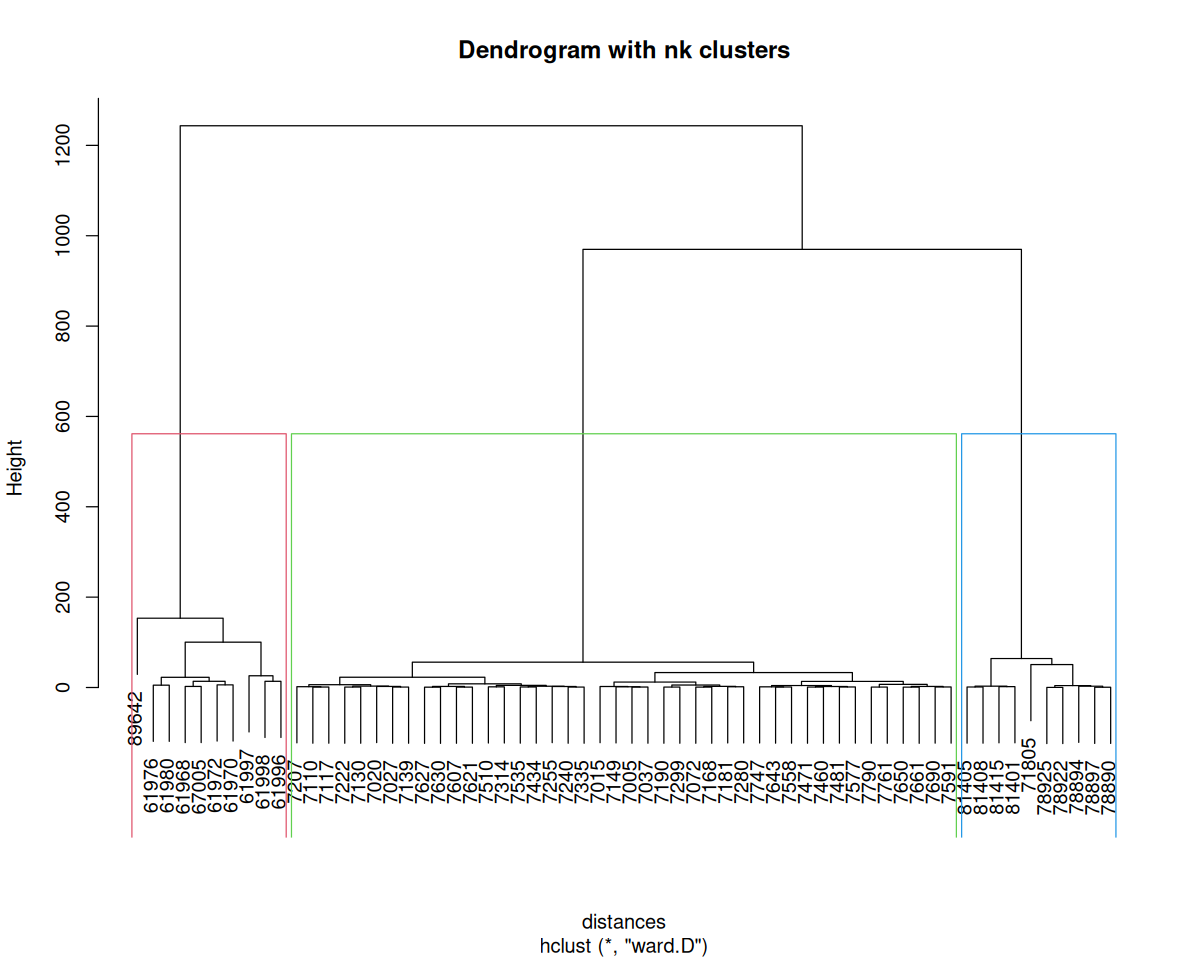

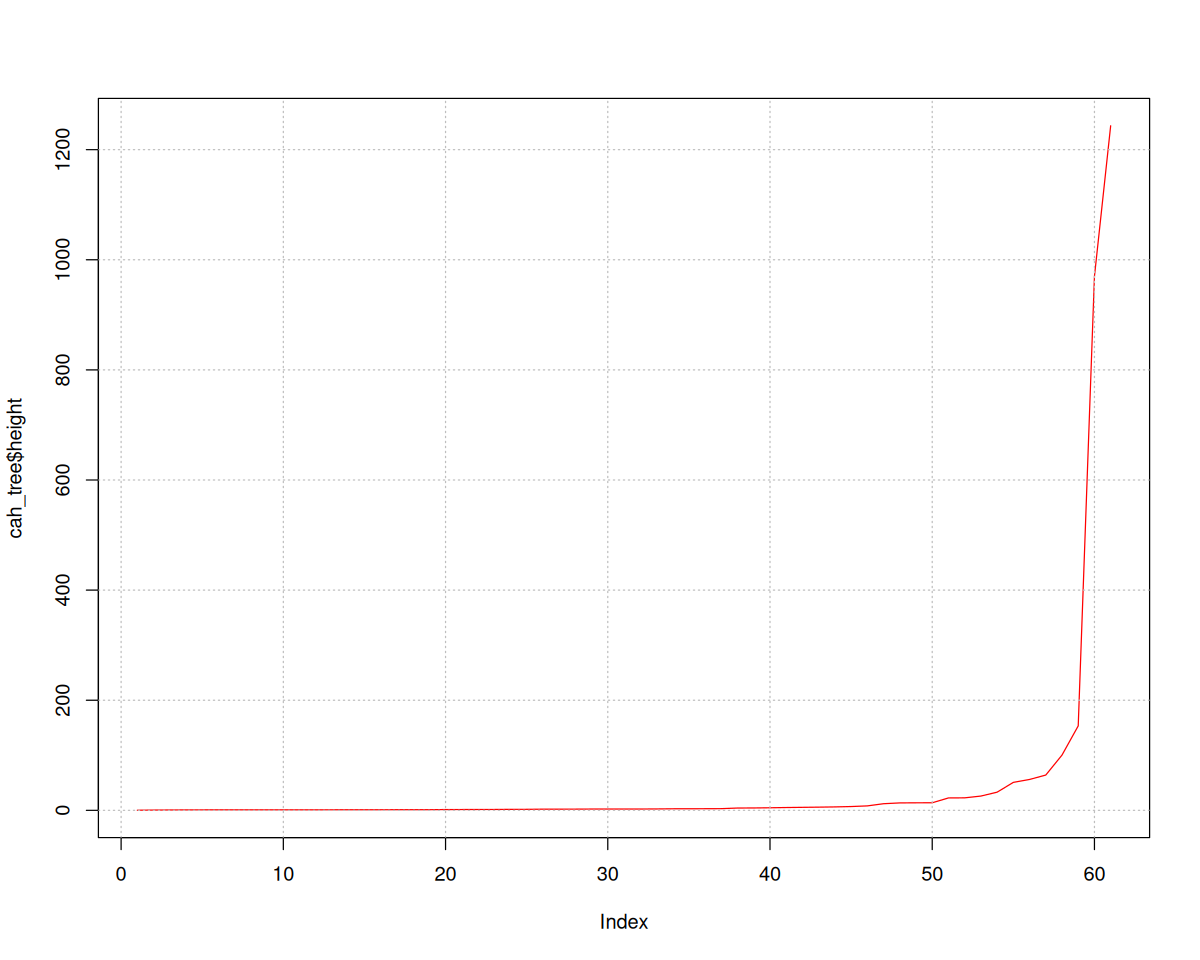

In [7]:
options(repr.plot.width=10, repr.plot.height=8)

nk = 3
# distances
distances <- dist(geo_data)
# la distance par défaut est 'complete', ie maximale.

# plot dendrogramme et sépare l'arbre
cah_tree <- hclust(distances, method="ward.D")
clusters <- cutree(cah_tree, k = nk, h = NULL)
par(bg = 'white')
plot(cah_tree, main = "Dendrogram with nk clusters")
rectlist = rect.hclust(cah_tree, k = nk, border = 2:(nk+1))

# plot la hauteur en fonction du nombre de groupe
print(cah_tree$height)
par(bg = 'white')
plot(cah_tree$height, col='red', type='l')
grid(col="gray")


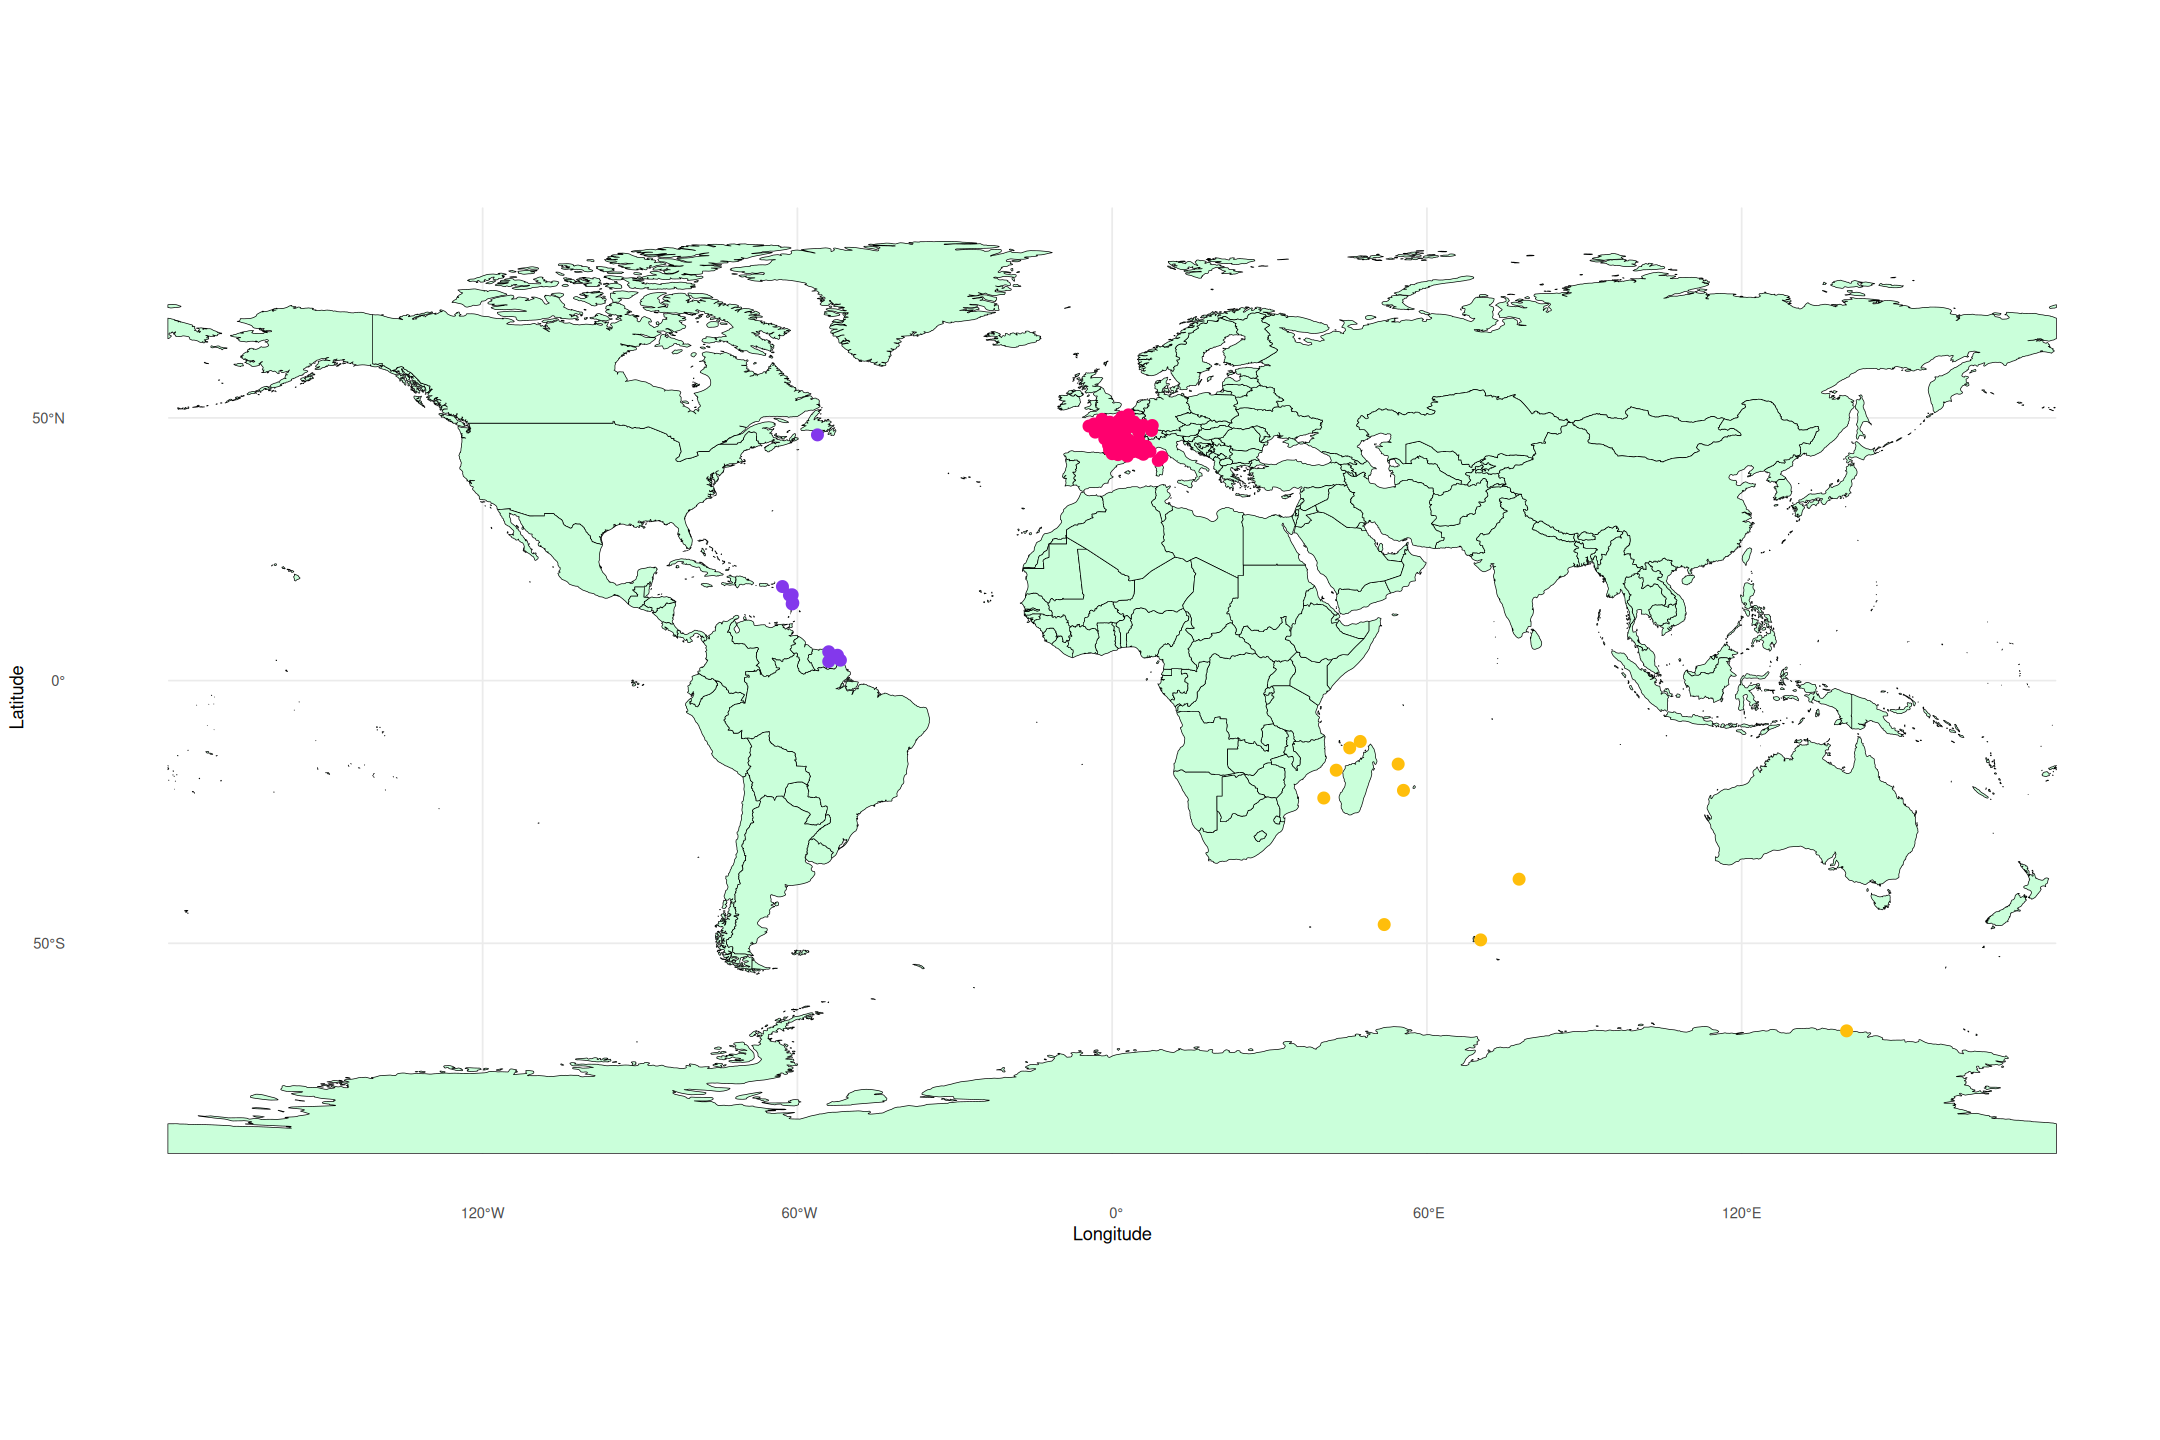

In [8]:
# en bleu, le groupe 1
# en rouge, le groupe 2
options(repr.plot.width=18, repr.plot.height=12)
worldmap <- ne_countries(scale = 'medium', type = 'map_units', returnclass = 'sf')

i <- 1
p <- ggplot()
p <- p + geom_sf(data = worldmap, color = "black", fill = "#CAFFDA")
for(v in rectlist){
    p <- p + geom_point(data = geo_data[rownames(geo_data) %in% names(v), ], 
              aes(x = Longitude, y = Latitude), color = pcolors[[i]], size = 3)
  i <- (i+1)%%4
}
p <- p + coord_sf() + theme_minimal()
print(p)


## Critère : Température

## Critère : Nébulosité